In [1]:
import sys
kaggle_path_prefix = "../input/mylibrary/"
sys.path.append(kaggle_path_prefix)

In [2]:
from mylibrary.models.misc import set_gpu_usage

set_gpu_usage()
from mylibrary.dataloader import dataset1
from mylibrary.dataloader.dataset import ClfSegDataset, get_balanced_loader, get_loader
#from mylibrary.dataloader.dataset import get_balanced_loader, get_loader
from mylibrary.models import densesharp, metrics, losses
from mylibrary import densenet
#from mylibrary.dataloader import dataset1
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from mylibrary.dataloader.dataset import Transform

batch_sizes=[3, 5, 8, 8]
crop_size=[32, 32, 32]
random_move=3
learning_rate=1.e-6
segmentation_task_ratio=0.2
weight_decay=0.01
save_folder='TrainedModel\densenet'
epochs=100


In [3]:
#得到训练数据
import os
import numpy as np
import pandas as pd
train_info=pd.read_csv("../input/train-data/train_val.csv")
train_nodule_path="../input/train-data/train_val/"
name = train_info.loc[:, 'name']
y_train=train_info.loc[:, 'label']
train_num=len(name)
xs = np.empty((train_num,*(32,32,32), 1))
segs=np.empty((train_num,*(32,32,32), 1))

for i in range(train_num):
        with np.load(os.path.join(train_nodule_path, '%s.npz' % name[i])) as npz:
            voxel=npz['voxel'][34:66,34:66,34:66]
            seg=npz['seg'][34:66,34:66,34:66]
            voxel=np.expand_dims(voxel,axis=-1)
            seg=np.expand_dims(seg,axis=-1)
            
            xs[i,]=voxel
            segs[i,]=seg
x_train=xs
x_train_seg=segs
print(x_train.shape)
print('seg shape',x_train_seg.shape)
#np.save('x_test.npy',x_test)
xseg_train=x_train*x_train_seg

from keras.utils import to_categorical
y_train=to_categorical(y_train,2)
print(y_train.shape )
num=445
x_all2=x_train*x_train_seg
y_all=y_train
x_all_seg=x_train_seg
xseg_train=x_all2[0:num].copy()
yseg_train=y_train[0:num].copy()
print(yseg_train.shape)


(465, 32, 32, 32, 1)
seg shape (465, 32, 32, 32, 1)
(465, 2)
(445, 2)


Using TensorFlow backend.


In [ ]:
#得到测试数据
import numpy as np
#x_all=np.load('../input/train-data/x_all.npy')
#y_all_orig=np.load('../input/train-data/y_all.npy')
from tensorflow.keras.utils import to_categorical
#y_all=to_categorical(y_all_orig,2)
all_num=len(y_all)
#print(x_all.shape)

num=all_num-0

#x_train=x_all[0:num].copy()
#y_train=y_all[0:num].copy()

x_test=np.load('../input/train-data/x_test.npy')

#x_all_seg=np.load('../input/train-data/x_all_seg.npy')
x_test_seg=np.load('../input/train-data/x_test_seg.npy')
print(x_all_seg.shape)
#x_all2=x_all*x_all_seg
xseg_test=x_test*x_test_seg

#xseg_train=x_all2[0:num].copy()
#yseg_train=y_all[0:num].copy()


In [ ]:
#数据增强
from mylibrary import augmentation
all_num=465
num=all_num-0

index1=np.random.randint(0,num,200)
index2=np.random.randint(0,num,200)
index3=np.random.randint(0,num,200)


'''
x_train2=x_all2[index1].copy()
y_train2=y_all[index1].copy()
seg2=x_all_seg[index1].copy()
x_train3=x_all2[index2].copy()
y_train3=y_all[index2].copy()
seg3=x_all_seg[index2].copy()
x_train4=x_all2[index3].copy()
y_train4=y_all[index3].copy()
seg4=x_all_seg[index3].copy()
'''

x_train2=x_all2[0:num].copy()
y_train2=y_all[0:num].copy()
seg2=x_all_seg[0:num].copy()
x_train3=x_all2[0:num].copy()
y_train3=y_all[0:num].copy()
seg3=x_all_seg[0:num].copy()
x_train4=x_all2[0:num].copy()
y_train4=y_all[0:num].copy()
seg4=x_all_seg[0:num].copy()

x_train2,y_train2,seg2=argumentation.flip_dim1(x_train2,y_train2,seg2)
x_train2,y_train2,seg2=argumentation.flip_dim2(x_train2,y_train2,seg2)

x_train3,y_train3,seg3=argumentation.flip_dim2(x_train3,y_train3,seg3)
x_train3,y_train3,seg3=argumentation.flip_dim3(x_train3,y_train3,seg3)

x_train4,y_train4,seg4=argumentation.flip_dim3(x_train4,y_train4,seg4)
x_train4,y_train4,seg4=argumentation.flip_dim1(x_train4,y_train4,seg4)


#x_train_mix,y_train_mix,seg_mix=argumentation.mix_up(x_all2[0:num],y_all[0:num],x_all_seg[0:num],0.2,300)

print(y_all.shape)
#x_train=x_train*seg_train
arg_x1=np.concatenate((x_train2,x_train3,x_train4))
arg_y1=np.concatenate((y_train2,y_train3,y_train4))
arg_seg=np.concatenate((seg2,seg3,seg4))

index = [i for i in range(num*3)]
# 下面这种写法也可以
# index = np.arange(len(dataset))
np.random.shuffle(index) # 打乱索引

arg_x1 = arg_x1[index]
arg_y1 = arg_y1[index]
arg_seg = arg_seg[index]
#x_train_mix2,y_train_mix2,seg_mix2=argumentation.mix_up(arg_x1,arg_y1,arg_seg,0.7,800)

#arg_x1=np.concatenate((x_train2,x_train3,x_train4))
#arg_y1=np.concatenate((y_train2,y_train3,y_train4))

print(arg_x1.shape)
print(arg_y1.shape)
#print(arg_y2[60])
#print(arg_x2[60][15][:][15][0])

"""
x_train2,y_train2=argumentation.flip_dim1(x_all,y_all)
x_train3,y_train3=argumentation.flip_dim2(x_all,y_all)
x_train4,y_train4=argumentation.flip_dim3(x_all,y_all)

x_train2,y_train2=argumentation.flip_dim2(x_train2,y_train2)
x_train3,y_train3=argumentation.flip_dim3(x_train3,y_train3)
x_train4,y_train4=argumentation.flip_dim1(x_train4,y_train4)
arg_x3=np.concatenate((x_train2,x_train3,x_train4))
arg_y3=np.concatenate((y_train2,y_train3,y_train4))
"""

In [ ]:
from mylibrary.utils.misc import plot_voxel_enhance
m=53
'''
b=x_all[m]
a=x_all[m]*x_all_seg[m]
d=x_all_seg[m]
c=x_all2[m]
e=x_test[m]
f=x_test_seg[m]
'''
#x_all2[90];
plot_voxel_enhance(arg_x1[799].squeeze(),arg_seg[799].squeeze(),alpha=0.2)

In [ ]:
#标签平滑
def label_smoothing(inputs, epsilon=0.1):
    K= inputs.shape[-1]# number of channels
    return ((1-epsilon) * inputs) + (epsilon / K)


In [ ]:
y_trainst=label_smoothing(yseg_train)
print(y_trainst[1])

In [ ]:
# aucroc指标
from tensorflow.keras import backend as K
from sklearn.metrics import roc_auc_score
import tensorflow as tf
# AUC for a binary classifier
def auc(y_true, y_pred):
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas * binSizes
    return K.sum(s, axis=0)
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)
    return FP/N
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)
    return TP/P


In [ ]:
#另一种得到增强数据的方式；借助densesharpdataset 中的数据增强
batch_size = sum(batch_sizes)

train_dataset1 = ClfSegDataset(crop_size=crop_size, subset=[ 0,1, 2, 3], move=random_move,
                                  define_label=lambda l: [l[0] ,l[1]])
train_dataset2= ClfSegDataset(crop_size=crop_size, subset=[ 0,1, 2, 3], move=random_move,
                                  define_label=lambda l: [l[0] ,l[1]])
val_dataset = ClfSegDataset(crop_size=crop_size, subset=[4,5], move=None,
                                define_label=lambda l: [l[0] , l[1]])

#train_loader = get_balanced_loader(train_dataset, batch_sizes=batch_sizes)
#val_loader = get_loader(val_dataset, batch_size=batch_size)

In [ ]:
clf_seg_dataset1 = dataset1.ClfSegDataset(crop_size=32, subset=[1,2,3,0], move=random_move)
clf_seg_dataset2 = dataset1.ClfSegDataset(crop_size=32, subset=[1,2,3,0], move=random_move)

In [ ]:
import numpy as np
train_num=len(clf_seg_dataset1)
x_train1= np.ones((train_num,32,32,32,1))
y_train1= np.ones((train_num,1))
seg_train1=np.ones((train_num,32,32,32,1))
print(x_train1.shape)
i=0
while i<train_num:
    x_train1[i],(y_train1[i],seg_train1[i])=clf_seg_dataset1[i]
    i+=1

from keras.utils import to_categorical
y_train1=to_categorical(y_train1,2)
print(y_train1[0])

In [ ]:
import numpy as np
train_num=len(clf_seg_dataset2)
x_train2= np.ones((train_num,32,32,32,1))
y_train2= np.ones((train_num,1))
seg_train2=np.ones((train_num,32,32,32,1))
print(x_train2.shape)
i=0
while i<train_num:
    x_train2[i],(y_train2[i],seg_train2[i])=clf_seg_dataset2[i]
    i+=1

from keras.utils import to_categorical
y_train2=to_categorical(y_train2,2)

In [ ]:
x_train_mix,y_train_mix,seg_mix=argumentation.mix_up(arg_x1,arg_y1,arg_seg,0.7,1200)

In [ ]:
arg_x1=np.concatenate((x_train1,x_train2))
arg_y1=np.concatenate((y_train1,y_train2))
arg_seg=np.concatenate((seg_train1,seg_train2))
#x_train_mix,y_train_mix,seg_mix=argumentation.mix_up(x_all2[0:num],y_all[0:num],x_all_seg[0:num],0.7,200)
print(arg_x1.shape)
print(arg_y1.shape)

In [ ]:
#编译densenet
import tensorflow as tf
densenet_model = densenet.get_compiled()

In [ ]:
#编译densesharp
learning_rate=1.e-3
segmentation_task_ratio=0.1
weight_decay=0.01
dropout_rate=0.0001
densesharp_model = densesharp.get_compiled(output_size=2,dropout_rate=dropout_rate,
                                    optimizer=Adam(lr=learning_rate),
                                    loss={"clf": 'categorical_crossentropy',
                                          "seg": losses.DiceLoss()},
                                    metrics={'clf': ['accuracy', metrics.precision, metrics.recall, metrics.fmeasure,
                                                     metrics.invasion_acc, metrics.invasion_fmeasure,
                                                     metrics.invasion_precision, metrics.invasion_recall,
                                                     metrics.ia_acc, metrics.ia_fmeasure,
                                                     metrics.ia_precision, metrics.ia_recall],
                                             'seg': [metrics.precision, metrics.recall, metrics.fmeasure]},
                                    loss_weights={"clf": 1., "seg": segmentation_task_ratio},
                                    weight_decay=weight_decay)

In [ ]:

checkpointer = ModelCheckpoint(filepath='../output/densenet/model/epo-{epoch:02d}-acc-{categorical_accuracy:.2f}-val-{val_categorical_accuracy:.2f}.hdf5', verbose=1,
                                   period=1, save_weights_only=False)
#checkpointer = ModelCheckpoint(filepath='tmp/%s/weights.{epoch:02d}.h5' % save_folder, verbose=1,
 #                                  period=1, save_weights_only=False)
best_keeper = ModelCheckpoint(filepath='best.h5' , verbose=1, save_weights_only=False,
                                  monitor='val_clf_acc', save_best_only=True, period=1, mode='max')
#csv_logger = CSVLogger('tmp\%s\training.csv' % save_folder)
csv_logger = CSVLogger('training.csv')

tensorboard = TensorBoard(log_dir='../output/densenet/logs')
early_stopping = EarlyStopping(monitor='val_clf_acc', min_delta=0, mode='max',
                                   patience=30, verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.334, patience=10,
                                   verbose=1, mode='min', epsilon=1.e-5, cooldown=2, min_lr=0)


In [5]:

#file_path= "./den-seg-base0arg0-epo-03-acc-0.70-val-0.71.hdf5"
file_path= "den-seg-epo-{epoch:02d}-acc-{categorical_accuracy:.2f}-val-{val_categorical_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath=file_path, monitor='val_categorical_accuracy', verbose=1, save_best_only=True,mode='auto')
tensorboard =TensorBoard(log_dir="densenet/log")
callback_lists=[tensorboard,checkpoint]

In [ ]:
#训练
net_history2=densenet_model.fit(xseg_train[0:num],y_trainst,validation_split=0.3,epochs=30,verbose=1,batch_size=64,
                                        # callbacks=[checkpoint, early_stopping, best_keeper, lr_reducer, csv_logger, tensorboard])
                        callbacks=[checkpoint,RocAuc,early_stopping])

In [ ]:

net_history3=densenet_model.fit(x_all2,y_all,validation_data=(x_all2,y_all),epochs=40,verbose=1,batch_size=32,
                                         #callbacks=[checkpoint, early_stopping, best_keeper, lr_reducer, csv_logger, tensorboard])
                        callbacks=[checkpoint,tensorboard])

In [ ]:
print(xseg_train.shape)
print(yseg_train.shape)

In [6]:
#sharp
file_path= "denp-seg-epo-{epoch:02d}-acc-{clf_accuracy:.2f}-val-{val_clf_accuracy:.2f}.hdf5"
#file_path= "den-seg-base-epo-{epoch:02d}-acc-{categorical_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath=file_path, monitor='val_clf_accuracy', verbose=1, save_best_only=True,mode='auto')
tensorboard =TensorBoard(log_dir="densesharp/log")
callback_lists=[tensorboard,checkpoint]

In [7]:
#训练sharp
sharp_hist=densesharp_model.fit(x_all2[0:464],(y_all[0:464],x_all_seg[0:464]),validation_data=(x_all2[0:464],(y_all[0:464],x_all_seg[0:464])),
                                epochs=40,verbose=1,batch_size=32,
                                        # callbacks=[checkpoint, early_stopping, best_keeper, lr_reducer, csv_logger, tensorboard])
                        callbacks=[checkpoint])

Train on 464 samples, validate on 464 samples
Epoch 1/40
448/464 [===========================>..] - ETA: 0s - loss: 0.6515 - clf_loss: 0.7422 - seg_loss: -0.4536 - clf_accuracy: 0.5692 - clf_precision: 0.5692 - clf_recall: 0.5692 - clf_fmeasure: 0.5692 - seg_precision: 0.6120 - seg_recall: 0.8855 - seg_fmeasure: 0.6914
Epoch 00001: val_clf_accuracy improved from -inf to 0.54095, saving model to denp-seg-epo-01-acc-0.57-val-0.54.hdf5
464/464 [==============================] - 25s 53ms/sample - loss: 0.6443 - clf_loss: 0.7332 - seg_loss: -0.4780 - clf_accuracy: 0.5733 - clf_precision: 0.5771 - clf_recall: 0.5771 - clf_fmeasure: 0.5771 - seg_precision: 0.6341 - seg_recall: 0.8878 - seg_fmeasure: 0.7074 - val_loss: 0.8187 - val_clf_loss: 0.8881 - val_seg_loss: -0.3717 - val_clf_accuracy: 0.5409 - val_clf_precision: 0.5437 - val_clf_recall: 0.5437 - val_clf_fmeasure: 0.5437 - val_seg_precision: 0.9930 - val_seg_recall: 0.6357 - val_seg_fmeasure: 0.7690
Epoch 2/40
448/464 [==================

In [ ]:
#加载模型
from tensorflow.keras.models import load_model
import tensorflow as tf
from mylibrary.models.losses import DiceLoss
from mylibrary.models.metrics import invasion_acc, invasion_precision, invasion_recall, invasion_fmeasure,precision, recall, fmeasure,ia_acc,ia_precision,ia_recall,ia_fmeasure
#file_path1='./seq_model/epo-06-acc-0.64-val-0.61.hdf5'
#file_path1='./den-seg-base0arg0-epo-03-acc-0.67-val-0.69.hdf5'

file_path1='../input/train-data/den-seg-base5-epo1-28-acc-0.74-val-0.73.hdf5'
#file_path1='./denp-seg-basearg1-epo-06-acc-0.72-val-0.73.hdf5'
#file_path1='./den-basearglre5adam-epo4-05-acc-0.70-val-0.64.hdf5'
custom_objects1={'invasion_acc': invasion_acc,'invasion_precision':invasion_precision,'invasion_recall':invasion_recall,'invasion_fmeasure':invasion_fmeasure,'dice_loss_100':DiceLoss(),
               'precision':precision,'recall':recall,'fmeasure':fmeasure,'ia_fmeasure':ia_fmeasure,'ia_acc':ia_acc,'ia_precision':ia_precision,'ia_recall':ia_recall}

#densesharp_model = tf.keras.models.load_model(file_path1, custom_objects=custom_objects1)
custom_objects={'invasion_acc': invasion_acc,'invasion_precision':invasion_precision,'invasion_recall':invasion_recall,'invasion_fmeasure':invasion_fmeasure}
#densenet_model= load_model(file_path1)
densenet_model.load_weights(file_path1)
#val_pre = model.predict(x_val, batch_size=5, verbose=1)
#score=model.evaluate
#test_pre=model.predict(x_test,batch_size=3,verbose=1)


In [ ]:
y_train_pred,segpre=densesharp_model.predict(x_all2)

In [ ]:
print(y_train_pred.shape)
a=auc(y_all[440:all_num-1],y_train_pred[440:all_num-1])
print(a)

In [ ]:
b=densesharp_model.evaluate(x_all2[440:all_num-1],(y_all[440:all_num-1],x_all_seg[440:all_num-1]))
print(b)

In [ ]:
densenet_model.save("den-seg-base5arg1-epo-20-acc-0.76-val-0.72.hdf5")

In [ ]:
all_num=len(y_all)
#score_test=densesharp_model.evaluate(x_all2[0:all_num-1],(y_all[0:all_num-1],x_all_seg[0:all_num-1]),verbose=1)

#print(y_pretrain[200:300])
score_test=densenet_model.evaluate(x_all2[0:100],y_all[0:100],verbose=1)

#score_test=densesharp_model.evaluate(x_all2[num:all_num-1],y_all[num:all_num-1],verbose=1)

#score_test=densesharp_model.evaluate(x_all2[0:464],(y_all[0:all_num-1],x_all_seg[0:all_num-1]),verbose=1,batch_size=16)
print('Testing loss: %.4f, Testing accuracy: %.2f%%' % (score_test[0],score_test[1]*100))

In [ ]:
score_test=densesharp_model.evaluate(x_all2[0:464](y_all[0:all_num-1],x_all_seg[0:all_num-1]),verbose=1,batch_size=16)
print('Testing loss: %.4f, Testing accuracy: %.2f%%' % (score_test[0],score_test[1]*100))

In [ ]:
#预测
y_pre,yseg_pre=densesharp_model.predict(x_all2)

In [ ]:
a=auc(y_all,y_pre)
print(a)
print(y_pre[0])

In [ ]:
#预留集上auc
y_pretrain=densenet_model.predict(x_all2[num:all_num-1])
a=auc(y_all[num:all_num-1],y_pretrain)
print(a)

In [ ]:
#总训练集上auc
y_pretrain=densenet_model.predict(x_all2)
a=auc(y_all,y_pretrain)
print(a)

In [ ]:
#得到test
import os
import numpy as np
import pandas as pd
test_info=pd.read_csv("../input/train-data/test_result.csv")
test_nodule_path="../input/train-data/test/test/"
name = test_info.loc[:, 'name']
test_num=len(name)
xs = np.empty((test_num,*(32,32,32), 1))
segs=np.empty((test_num,*(32,32,32), 1))

for i in range(test_num):
        with np.load(os.path.join(test_nodule_path, '%s.npz' % name[i])) as npz:
            voxel=npz['voxel'][34:66,34:66,34:66]
            seg=npz['seg'][34:66,34:66,34:66]
            voxel=np.expand_dims(voxel,axis=-1)
            seg=np.expand_dims(seg,axis=-1)
            
            xs[i,]=voxel
            segs[i,]=seg
x_test=xs
x_test_seg=segs
print(x_test.shape)
print('seg shape',x_test_seg.shape)
#np.save('x_test.npy',x_test)
xseg_test=x_test*x_test_seg

In [ ]:
#数据预测与保存
y_test_pre,yseg=densesharp_model.predict(xseg_test)

y_test1=y_test_pre[:,[1]]
#y_test1[5]
#y_test_pre[[5]]
test_num=len(xseg_test)
import pandas as pd

file_name="submission sharp.csv"
test_list = pd.read_table("../input/train-data/test_result.csv",sep = ",")['name']
test_name = np.array(test_list).reshape(test_num)
#print(y_test_pre.shape)
load_predicted = np.array(y_test1).reshape(test_num)
load_test_dict = {'name':test_name, 'Predicted':load_predicted}
load_result = pd.DataFrame(load_test_dict, index = [0 for _ in range(test_num)])
load_result.to_csv(file_name, index = False, sep = ',')


In [ ]:
print(net_history2.history.keys())

In [ ]:
import matplotlib.pyplot as plt
plt.plot(net_history2.history['categorical_accuracy'], label='acc')
plt.plot(net_history2.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
print(history.history.keys())

In [ ]:
import matplotlib.pyplot as plt
plt.plot(net_history3.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(net_history3.history['categorical_crossentropy'], label='categorical_crossentropy')

#plt.plot(net_history2.history['ROC_AUC'], label = 'ROC_AUC')
#plt.plot(net_history2.history['ROC_AUC'], label = 'ROC_AUC')
plt.xlabel('Epoch')
plt.ylabel('train')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.title("3D-Densenet")
plt.savefig('3d net_train.png')

In [ ]:

plt.plot(net_history3.history['val_categorical_accuracy'], label = 'val_categorical_accuracy')
plt.plot(net_history3.history['categorical_accuracy'], label='categorical_accuracy')
#plt.plot(net_history3.history['val_categorical_crossentropy'], label = 'val_categorical_crossentropy')
#plt.plot(net_history2.history['ROC_AUC'], label = 'ROC_AUC')
#plt.plot(net_history2.history['ROC_AUC'], label = 'ROC_AUC')
plt.xlabel('Epoch')
plt.ylabel('val')
plt.ylim([0.4, 1.5])
plt.legend(loc='lower right')
plt.title("3D-Densenet")
plt.savefig('3d densenet_val.png')

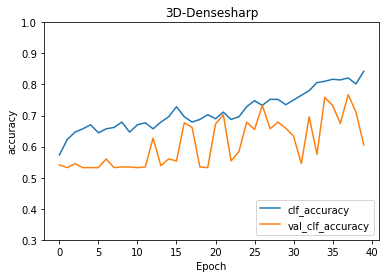

In [8]:
import matplotlib.pyplot as plt
plt.plot(sharp_hist.history['clf_accuracy'], label='clf_accuracy')
plt.plot(sharp_hist.history['val_clf_accuracy'], label = 'val_clf_accuracy')

#plt.plot(net_history2.history['ROC_AUC'], label = 'ROC_AUC')
#plt.plot(net_history2.history['ROC_AUC'], label = 'ROC_AUC')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.title("3D-Densesharp")
plt.savefig('3d sharp_acc.png')

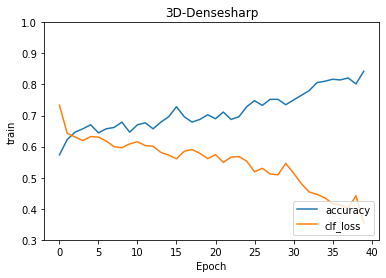

In [9]:
plt.plot(sharp_hist.history['clf_accuracy'], label='accuracy')
plt.plot(sharp_hist.history['clf_loss'], label = 'clf_loss')

#plt.plot(net_history2.history['ROC_AUC'], label = 'ROC_AUC')
#plt.plot(net_history2.history['ROC_AUC'], label = 'ROC_AUC')
plt.xlabel('Epoch')
plt.ylabel('train')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.title("3D-Densesharp")
plt.savefig('3d sharpnet trainaccloss.png')